import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from windrose import WindroseAxes

In [13]:
import pandas as pd

df = pd.read_csv('../data/Togo/processed/togo_clean.csv')


In [14]:
display(df.shape)


(3, 3)

In [15]:
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   region          3 non-null      object
 1   solar_capacity  3 non-null      int64 
 2   year            3 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 204.0+ bytes


None

In [16]:
display(df.head())

,region,solar_capacity,year
0,Togo,60,2020
1,Togo,75,2021
2,Togo,85,2022


In [18]:
import numpy as np

display(df.describe(include=[np.number]))


,solar_capacity,year
count,3.000000,3.0
mean,73.333333,2021.0
std,12.583057,1.0
min,60.000000,2020.0
25%,67.500000,2020.5
50%,75.000000,2021.0
75%,80.000000,2021.5
max,85.000000,2022.0


In [19]:
missing_report = df.isna().sum().sort_values(ascending=False)
missing_percentage = (df.isna().mean() * 100).sort_values(ascending=False)
missing_df = pd.concat([missing_report, missing_percentage], axis=1)
missing_df.columns = ['Missing Count', 'Missing Percentage']
display(missing_report)
display(missing_df[missing_df['Missing Percentage'] > 5])

region            0
solar_capacity    0
year              0
dtype: int64

,Missing Count,Missing Percentage


In [21]:
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

def detect_outliers(df, columns, threshold=3):
    df = df.copy()
    df['Outlier_Flag'] = False  

    for col in columns:
        if col in df.columns:
            z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))
            df['Outlier_Flag'] |= (z_scores > threshold)
    
    total_outliers = df['Outlier_Flag'].sum()
    percent = total_outliers / len(df) * 100
    print(f"Detected {total_outliers} outlier rows ({percent:.2f}% of total).")
    
    return df
df = detect_outliers(df, key_columns)

Detected 0 outlier rows (0.00% of total).


In [22]:
df.isna().sum()

region            0
solar_capacity    0
year              0
Outlier_Flag      0
dtype: int64

In [24]:
key_cols = ['region', 'year', 'solar_capacity']

for col in key_cols:
    if col in df.columns:
        if df[col].isna().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    else:
        print(f"Warning: Column '{col}' not found in dataframe.")


In [26]:
df = pd.read_csv('../data/Togo/processed/togo_clean.csv', index_col=False)


In [28]:
print(df.columns)


Index(['region', 'solar_capacity', 'year'], dtype='object')


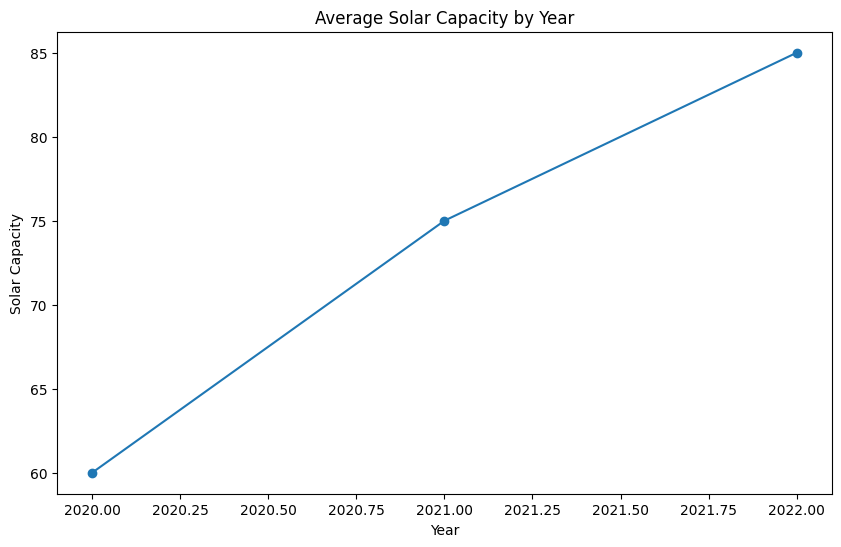

In [29]:
import matplotlib.pyplot as plt

df.groupby('year')['solar_capacity'].mean().plot(kind='line', marker='o', figsize=(10,6))
plt.title('Average Solar Capacity by Year')
plt.xlabel('Year')
plt.ylabel('Solar Capacity')
plt.show()


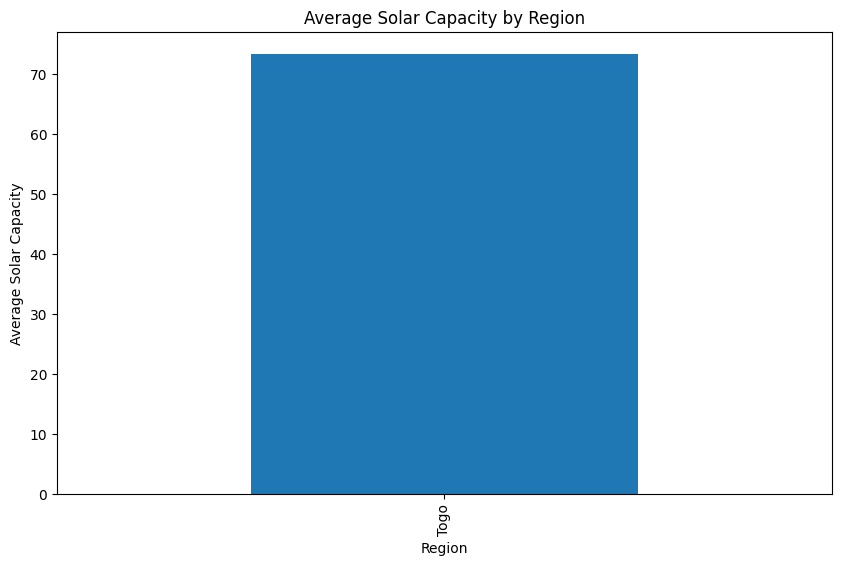

In [31]:
grouped = df.groupby('region')['solar_capacity'].mean()
grouped.plot(kind='bar', figsize=(10,6))
plt.title('Average Solar Capacity by Region')
plt.xlabel('Region')
plt.ylabel('Average Solar Capacity')
plt.show()


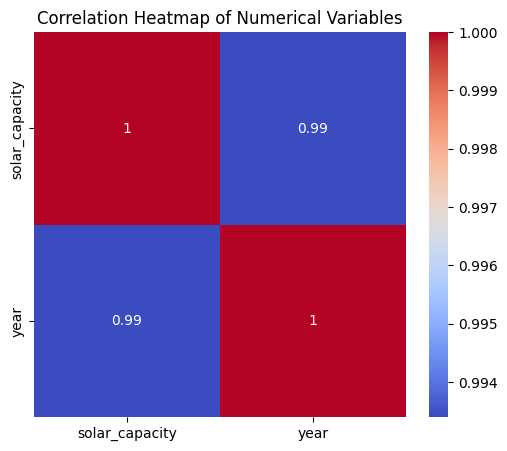

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include='number').columns
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


ValueError: Could not interpret value `WS` for `x`. An entry with this name does not appear in `data`.

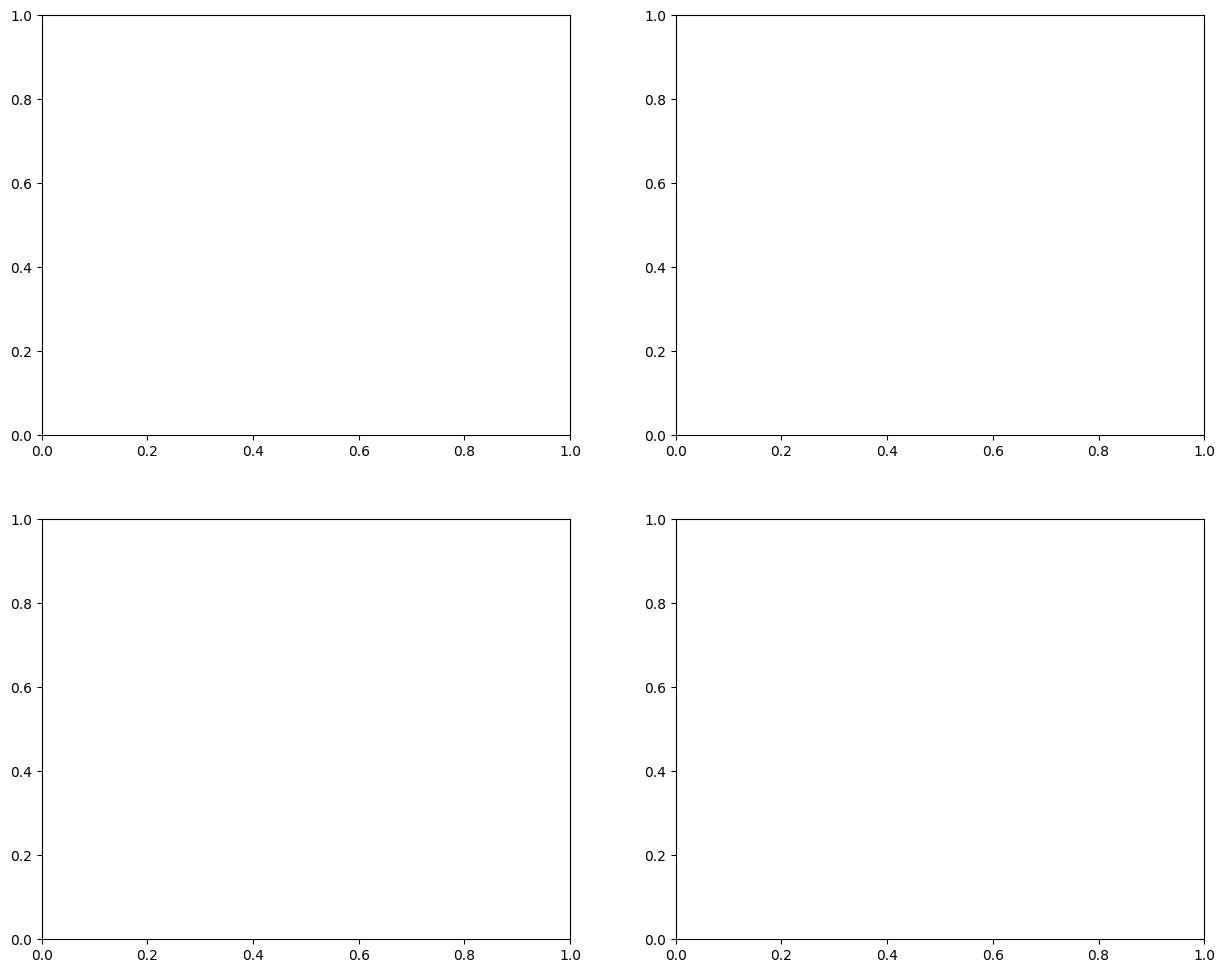

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
sns.scatterplot(data=df, x='WS', y='GHI', ax=axes[0, 0])
sns.scatterplot(data=df, x='WSgust', y='GHI', ax=axes[0, 1])
sns.scatterplot(data=df, x='RH', y='Tamb', ax=axes[1, 0])
sns.scatterplot(data=df, x='RH', y='GHI', ax=axes[1, 1])
plt.tight_layout()
plt.show()


KeyError: 'WD'

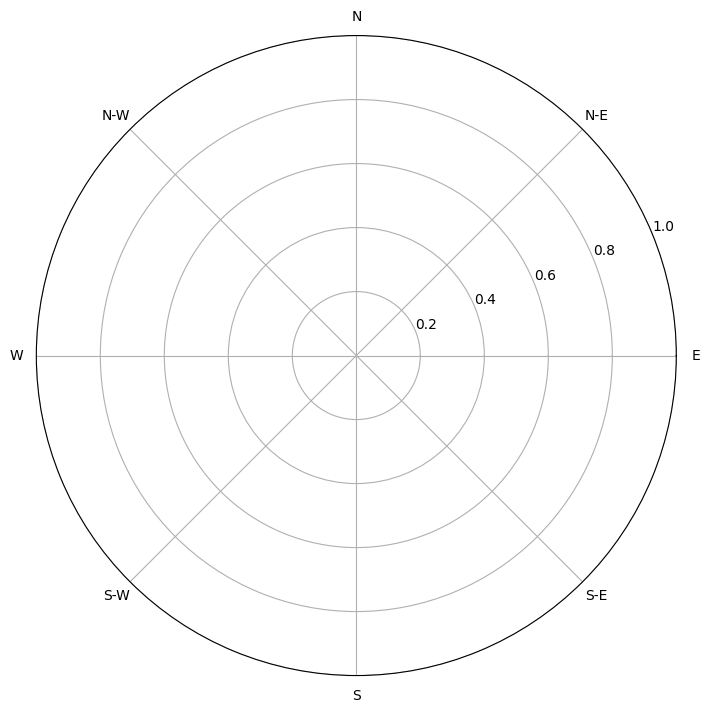

In [37]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Create wind rose plot
fig = plt.figure(figsize=(12, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title='Wind Speed (m/s)')
plt.title('Wind Rose Diagram')
plt.show()

# Histograms for GHI and Wind Speed
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df['GHI'].plot(kind='hist', bins=50, ax=axes[0], title='GHI Distribution')
df['WS'].plot(kind='hist', bins=50, ax=axes[1], title='Wind Speed Distribution')
plt.tight_layout()
plt.show()


KeyError: 'RH'

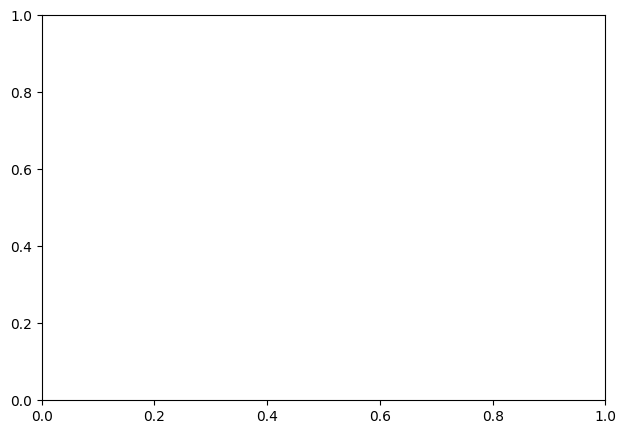

In [38]:
plt.figure(figsize=(16, 5))  
plt.subplot(1, 2, 1)  
plt.scatter(df['RH'], df['Tamb'], alpha=0.5)
plt.title('Ambient Temperature vs Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.grid(True)


plt.subplot(1, 2, 2) 
plt.scatter(df['RH'], df['GHI'], alpha=0.5)
plt.title('GHI vs Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.grid(True)


plt.tight_layout()
plt.show()

In [11]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Tamb'], df['GHI'], s=df['RH']*2, alpha=0.5, 
                     c=df['BP'], cmap='viridis')
plt.colorbar(scatter, label='Barometric Pressure (hPa)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Temperature (Bubble Size = RH, Color = BP)')
plt.show()

NameError: name 'plt' is not defined